In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)  # Import for ROC/AUC
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageChops, ImageEnhance

In [2]:

class ForgeryDetector:
    def __init__(self, dataset_path, image_size=(160, 160)):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.model = None
        self.history = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def gaussian_blur_difference(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        diff = cv2.absdiff(gray, blurred)
        diff_color = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
        return diff_color

    def error_level_analysis(self, image, quality=98):
        try:
            im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            temp_compressed = 'temp_compressed.jpg'
            im.save(temp_compressed, 'JPEG', quality=quality)
            compressed = Image.open(temp_compressed)
            ela_image = ImageChops.difference(im, compressed)
            ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
            os.remove(temp_compressed)
            ela_cv = cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
            return ela_cv
        except Exception as e:
            print(f"ELA Error: {e}")
            return None

    def preprocess_image(self, image):
        gb_diff = self.gaussian_blur_difference(image)
        ela_image = self.error_level_analysis(image)

        if ela_image is None:
            return None

        gb_resized = cv2.resize(gb_diff, self.image_size)
        ela_resized = cv2.resize(ela_image, self.image_size)

        combined = cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)
        return combined

    def prepare_dataset(self):
        X, y = [], []

        for class_name in ['Au', 'Tp']:
            class_path = os.path.join(self.dataset_path, class_name)
            label = 0 if class_name == 'Au' else 1

            for img_file in os.listdir(class_path):
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff','.bmp')):
                    continue
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                processed_img = self.preprocess_image(img)

                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)

        X = np.array(X)
        y = np.array(y)
        return X, y

    def build_model(self):
        input_tensor = Input(shape=(self.image_size[0], self.image_size[1], 3))
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_tensor=input_tensor
        )

        base_model.trainable = False

        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=base_model.input, outputs=output)

        self.model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return self.model

    def train_model(self, X, y):
        X = preprocess_input(X)

        # Standard Data Splitting
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
        )

        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

        print("Model Summary:")
        self.model.summary()

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),  # Single validation set
            epochs=50, # Adjust as needed
            batch_size=32, # Adjust as needed
            class_weight={0: 1., 1: 2.}  # If data is imbalanced
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    def plot_training_curves(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()

    def evaluate_model(self, X_test, y_test):
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("\nEvaluation on TEST Set:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Forged', 'Forged'],
                    yticklabels=['Non-Forged', 'Forged'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
        plt.plot

/var/folders/rz/1_0vymm50cxb84f_6l23t6j80000gn/T/ipykernel_3451/2770174178.py:73: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 35,552,321 (135.62 MB)

 Trainable params: 33,294,337 (127.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 160, 160, 3))
  warnings.warn(msg)


237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 435ms/step - accuracy: 0.6582 - loss: 1.0775 - val_accuracy: 0.7915 - val_loss: 0.4769
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 97s 409ms/step - accuracy: 0.7841 - loss: 0.6523 - val_accuracy: 0.8066 - val_loss: 0.4520
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 97s 408ms/step - accuracy: 0.8152 - loss: 0.5735 - val_accuracy: 0.8197 - val_loss: 0.4158
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 97s 411ms/step - accuracy: 0.8284 - loss: 0.5341 - val_accuracy: 0.8276 - val_loss: 0.4127
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 99s 418ms/step - accuracy: 0.8452 - loss: 0.4845 - val_accuracy: 0.8284 - val_loss: 0.4229
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 98s 412ms/step - accuracy: 0.8687 - loss: 0.4218 - val_accuracy: 0.8351 - val_loss: 0.4150
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 98s 413ms/step - accuracy: 0.8798 - loss: 0.3957 - val_accuracy: 0.8383 - val_loss: 0.4117
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 98s 413ms/step - accuracy: 0.8895 - loss: 0.3478 - va

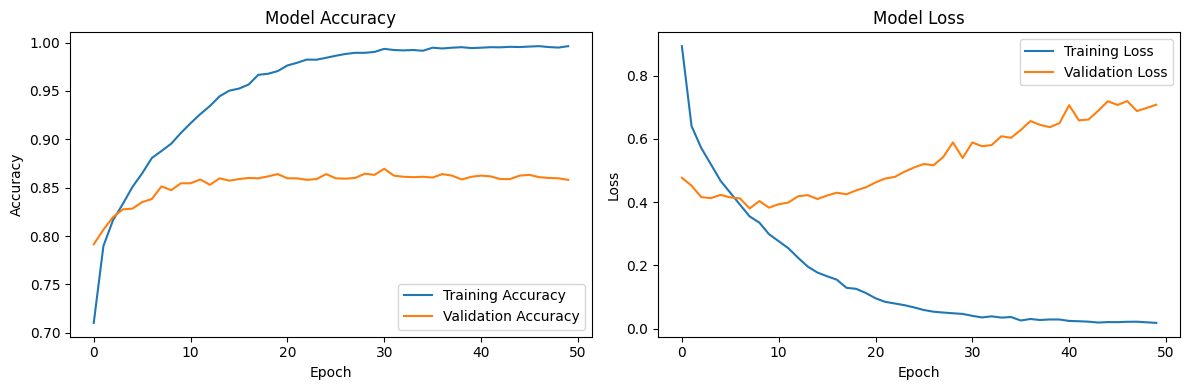

/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 160, 160, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step

Evaluation on TEST Set:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1498
           1       0.81      0.84      0.82      1025

    accuracy                           0.85      2523
   macro avg       0.85      0.85      0.85      2523
weighted avg       0.85      0.85      0.85      2523



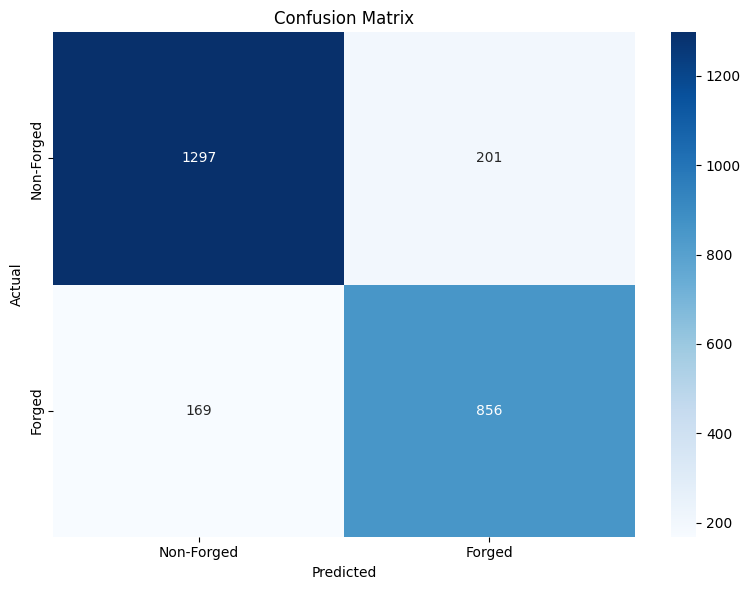


Test Metrics: None


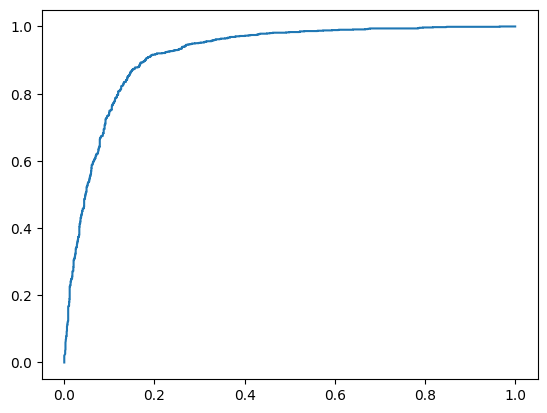

In [3]:
dataset_path = r"./CASIA22"
detector = ForgeryDetector(dataset_path)

# 1. Prepare the dataset:
X, y = detector.prepare_dataset()

# Check if data loading was successful before proceeding
if X is not None and y is not None:
    # 2. Build the model:
    detector.build_model()

    # 3. Train the model:
    X_train, X_val, X_test, y_train, y_val, y_test = detector.train_model(X, y)

    # 4. Plot training curves:
    detector.plot_training_curves()

    # 5. Evaluate the model on the TEST set:
    test_metrics = detector.evaluate_model(X_test, y_test)
    print("\nTest Metrics:", test_metrics)

    # Optional: Evaluate on the validation set as well:
    # val_metrics = detector.evaluate_model(X_val, y_val)
    # print("\nValidation Metrics:", val_metrics)

else:
    print("Error in dataset preparation. Check file paths and image formats.")
